In [1]:
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa

import matplotlib.pyplot as plt
import seaborn as sns

import basics

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
filenames = basics.get_and_shuffle_filenames("./recordings")

print(filenames[:5])

['./recordings/2_jackson_13.wav', './recordings/6_george_34.wav', './recordings/7_george_5.wav', './recordings/1_yweweler_21.wav', './recordings/2_george_42.wav']


In [3]:
X_unfiltered = [(file_path, basics.decode_audio(file_path)) for file_path in filenames]

# to remove outliers 
max_length = basics.get_max_length(X_unfiltered)
print(max_length)

5632


In [4]:
def mel_spec(signal):
    mel_spect = librosa.feature.melspectrogram(y=signal, sr=8000, n_fft=248, hop_length=248)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    return mel_spect

In [8]:
X_full = [] # padded X values
y_full = []

numbers = [0] * 10

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = basics.get_label(file_path)
    
    signal_length = audio.shape[0]
    if signal_length > max_length:
        numbers[y_val] += 1
        continue
        
    x_val = np.pad(
        x_val, (0, max_length - signal_length), 
        'constant', constant_values=(0, 0))

    mel_x = mel_spec(x_val).flatten()

    X_full.append(mel_x)
    y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

num_samples, sample_w = X_full.shape
print(num_samples)
print(sample_w)

2896
2944


In [9]:
# dropped outliers
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          12
1           9
2           7
3           9
4           3
5           8
6          29
7          11
8           6
9          10
104


In [10]:
tenth = int(num_samples * 0.1)
eightyth = tenth * 8

X_train = X_full[:eightyth]
y_train = y_full[:eightyth]

X_val = X_full[eightyth: eightyth + tenth]
y_val = y_full[eightyth: eightyth + tenth]

X_test = X_full[eightyth + tenth:]
y_test = y_full[eightyth + tenth:]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 2312
Validation set size 289
Test set size 295


In [11]:
# INPUTS ARE NORMALIZED

model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(sample_w,)))
model.add(tf.keras.layers.Reshape((128, 23, 1), input_shape=(sample_w,)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 23, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 126, 21, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 19, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 9, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 9, 64)         0         
                                                                 
 flatten (Flatten)           (None, 35712)             0         
                                                        

2022-05-07 18:23:46.885201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Epoch 1/30
73/73 [==============================] - 9s 117ms/step - loss: 12.5153 - accuracy: 0.2889 - val_loss: 1.1336 - val_accuracy: 0.6920
Epoch 2/30
73/73 [==============================] - 9s 125ms/step - loss: 0.8918 - accuracy: 0.7067 - val_loss: 0.4537 - val_accuracy: 0.8443
Epoch 3/30
73/73 [==============================] - 8s 110ms/step - loss: 0.4800 - accuracy: 0.8352 - val_loss: 0.3081 - val_accuracy: 0.9066
Epoch 4/30
73/73 [==============================] - 8s 112ms/step - loss: 0.4046 - accuracy: 0.8681 - val_loss: 0.2740 - val_accuracy: 0.9100
Epoch 5/30
73/73 [==============================] - 8s 115ms/step - loss: 0.3461 - accuracy: 0.8862 - val_loss: 0.1684 - val_accuracy: 0.9619
Epoch 6/30
73/73 [==============================] - 9s 120ms/step - loss: 0.2278 - accuracy: 0.9226 - val_loss: 0.1468 - val_accuracy: 0.9446
Epoch 7/30
73/73 [==============================] - 8s 111ms/step - loss: 0.1941 - accuracy: 0.9360 - val_loss: 0.1457 - val_accuracy: 0.9550
Epoch

In [14]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 25ms/step - loss: 0.3201 - accuracy: 0.9424


[0.32010841369628906, 0.9423728585243225]

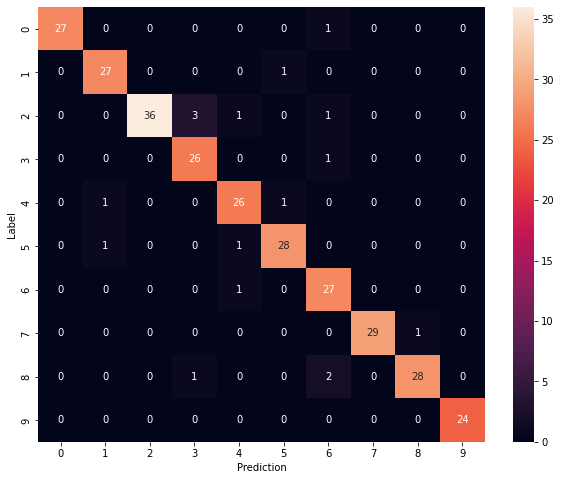

In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(10))

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=all_labels,
            yticklabels=all_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [16]:
model.save("model_v4.h5")